# Data Analysis

Este proyecto se centra en la aplicación de técnicas de análisis de datos y deep learning utilizando la librería PyTorch para abordar un problema de negocio crítico: la predicción de rotación de clientes o abandono (Churn). El objetivo principal es construir un modelo capaz de identificar, con la mayor precisión posible, qué clientes tienen una alta probabilidad de abandonar el servicio.

Se usará el conjunto de datos ["Telco Customer Churn" de Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

Durante todo el proceso se hará uso de Power BI tanto para el análisis de los datos y para el análisis de los resultados. En el siguiente [enlace](https://drive.google.com/file/d/16Eoe0G6OicPdTxLhT4oDghZp4nS08g-1/view?usp=sharing) se puede descargar el dashboard completo de Power BI.

## 0. Introducción (Power BI)

Se observa el perfil de los clientes para entender que puede haber factores que estén impulsando el abandono (Churn), la métrica más crítica.

Esta matriz de visualizaciones proporciona una visión general y rápida de cómo se distribuyen los clientes en función de sus características demográficas y de los servicios que consumen.

El punto central de nuestro análisis es el gráfico de tarta, el recuento de clientes por abandono. Como se puede observar, el 73.46% de los clientes permanecen, pero el 26.54% está abandonando el servicio.

Cada uno de estos gráficos de barras muestra qué grupos demográficos y qué servicios tienen la mayor propensión a esta fuga, enfocándonos especialmente en el patrón de los clientes que han dicho "Sí" al abandono. A continuación, se realizará un modelo de deep learning para predecir qué clientes tienen mayor riesgo de abandono.

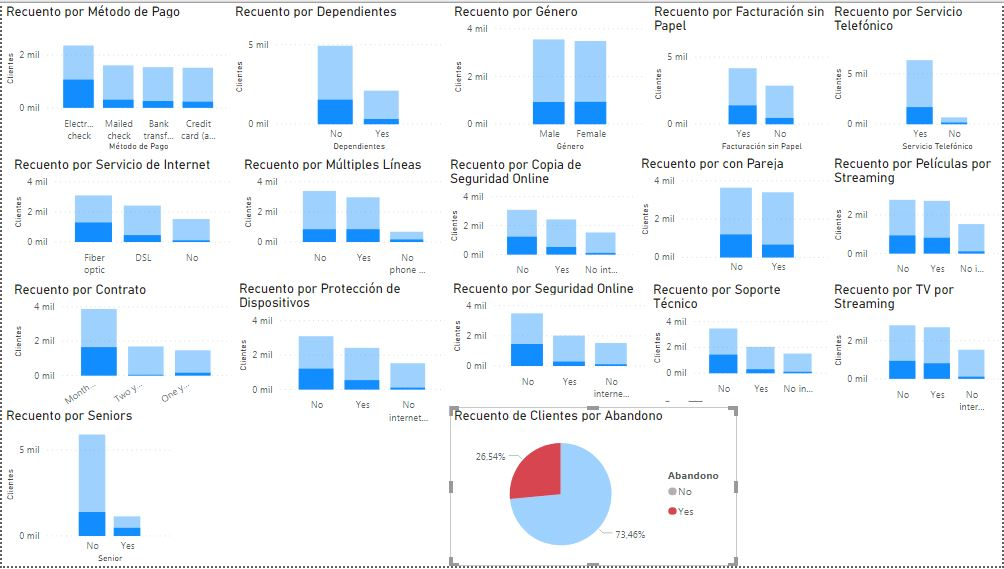

## 1. Carga de los datos y pre-procesamiento

Esta sección inicial se enfoca en la carga del dataset, la exploración preliminar, la limpieza de datos (manejo de nulos y conversión de tipos), y la codificación de variables categóricas para preparar los datos para PyTorch.

In [ ]:
# Se conecta con Google Drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        # Importante para que las operaciones deterministas se ejecuten en CUDA
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Puede ralentizar, pero asegura el determinismo

set_seed(42)

In [ ]:
dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/WA_Fn-UseC_-Telco-Customer-Churn.csv'
ds = pd.read_csv(dataset_path)
print(ds.head())
ds.info()
print(ds.isnull().sum())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

Cada fila representa a un cliente y cada columna contiene sus atributos.

El conjunto de datos incluye información sobre:

Clientes que se dieron de baja en el último mes.

Servicios contratados por cada cliente: telefonía, líneas múltiples, internet, seguridad en línea, copias de seguridad en línea, protección de dispositivos, soporte técnico y streaming de TV y películas.

Información de la cuenta del cliente: antigüedad, tipo de contrato, método de pago, facturación electrónica, cargos mensuales y total a pagar.

Información demográfica de los clientes: sexo, rango de edad y si tienen pareja o personas a su cargo.

In [ ]:
ds_procesado = ds.drop('customerID', axis=1)
ds_procesado['TotalCharges'] = pd.to_numeric(ds_procesado['TotalCharges'], errors='coerce')
ds_procesado['TotalCharges'].isnull().sum()

np.int64(11)

Los nulos se convierten en ceros, ya que como se observa en Power BI, son clientes que todavía no llevan un mes.

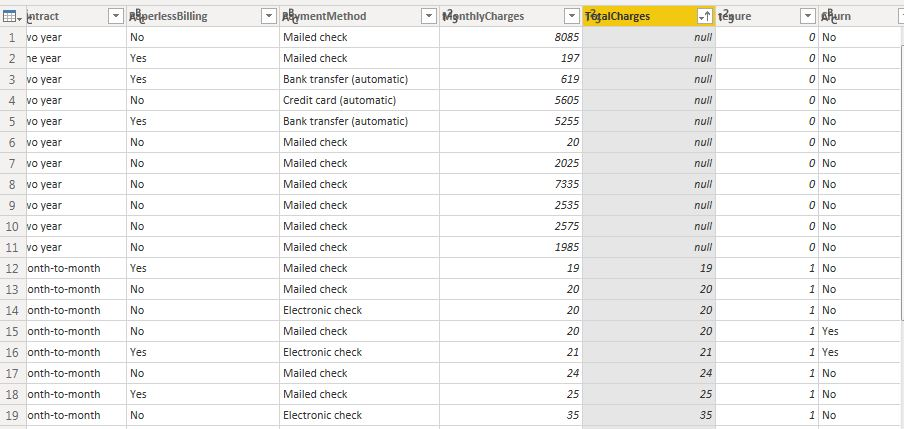

In [ ]:
ds_procesado['TotalCharges'] = ds_procesado['TotalCharges'].fillna(0)
print(f"Número de ejemplos total: {len(ds_procesado)}")

Número de ejemplos total: 7043


In [ ]:
print(f"Número de columnas antes del pre-procesado: {len(ds_procesado.columns)}")

for col in ds_procesado.columns:
    if ds_procesado[col].dtype == 'object':
        unique_vals = ds_procesado[col].unique()
        if len(unique_vals) == 2:
            if 'Yes' in unique_vals and 'No' in unique_vals:
                ds_procesado[col] = ds_procesado[col].map({'Yes': 1, 'No': 0}).astype(int)
            elif 'Female' in unique_vals and 'Male' in unique_vals:
                ds_procesado[col] = ds_procesado[col].map({'Female': 0, 'Male': 1}).astype(int)

ds_procesado = pd.get_dummies(ds_procesado, columns=ds_procesado.select_dtypes(include=['object']).columns, drop_first=True, dtype=int)

print(ds_procesado.head())

Número de columnas antes del pre-procesado: 20
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0                0                                0            

## 2. Preparar el conjunto de datos.

Se separan los datos para entrenamiento (80%), validación (10%) y prueba final (10%). Se escalan las variables numéricas y se crean los tensores de PyTorch.

In [ ]:
x = ds_procesado.drop('Churn', axis=1)
y = ds_procesado['Churn']

x_train, x_t, y_train, y_t = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_t, y_t, test_size=0.5, random_state=42, stratify=y_t)

columnas_normalizar = ['tenure', 'MonthlyCharges', 'TotalCharges']

MinMax = MinMaxScaler()

x_train[columnas_normalizar] = MinMax.fit_transform(x_train[columnas_normalizar])
x_val[columnas_normalizar] = MinMax.transform(x_val[columnas_normalizar])
x_test[columnas_normalizar] = MinMax.transform(x_test[columnas_normalizar])

print(f"Forma del train: {x_train.shape}, {y_train.shape}")
print(f"Forma del val: {x_val.shape}, {y_val.shape}")
print(f"Forma del test: {x_test.shape}, {y_test.shape}")

Forma del train: (5634, 30), (5634,)
Forma del val: (705, 30), (705,)
Forma del test: (704, 30), (704,)


In [ ]:
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

x_val_tensor = torch.tensor(x_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

print(f"Forma del tensor X_train: {x_train_tensor.shape}")
print(f"Forma del tensor y_train: {y_train_tensor.shape}")

Forma del tensor X_train: torch.Size([5634, 30])
Forma del tensor y_train: torch.Size([5634, 1])


In [ ]:
class ChurnDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

train_dataset = ChurnDataset(x_train_tensor, y_train_tensor)
val_dataset = ChurnDataset(x_val_tensor, y_val_tensor)
test_dataset = ChurnDataset(x_test_tensor, y_test_tensor)

In [ ]:
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 3. Se crea la red neuronal

Se define la Red Neuronal Feedforward (FFNN) en PyTorch. Esta red, llamada "RedNeuronal", utiliza cinco capas ocultas densas con activación ReLU y una alta tasa de Dropout (0.6) para mitigar el sobreajuste. El modelo se mueve al dispositivo disponible (GPU/CPU) para optimizar el entrenamiento.

In [ ]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Usando {device}")

Usando cuda


In [ ]:
input = x_train_tensor.shape[1]
print(f"Número de características de entrada: {input}")

class RedNeuronal(nn.Module):
    def __init__(self, input_size):
        super(RedNeuronal, self).__init__()

        capa1 = 500
        capa2 = 250
        capa3 = 125
        capa4 = 64
        capa5 = 32
        dropout_rate = 0.6

        self.fc1 = nn.Sequential(
            nn.Linear(input_size, capa1),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(capa1, capa2),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(capa2, capa3),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.fc4 = nn.Sequential(
            nn.Linear(capa3, capa4),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.fc5 = nn.Sequential(
            nn.Linear(capa4, capa5),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.output = nn.Linear(capa5, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.output(x)
        return x

Número de características de entrada: 30


In [ ]:
model = RedNeuronal(input_size=input).to(device)
print(model)

RedNeuronal(
  (fc1): Sequential(
    (0): Linear(in_features=30, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=500, out_features=250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=250, out_features=125, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (fc4): Sequential(
    (0): Linear(in_features=125, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (fc5): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
  )
  (output): Linear(in_features=32, out_features=1, bias=True)
)


## 4. Entrenamiento del modelo

Se utiliza el optimizador Adam con una tasa de aprendizaje (lr) de 0.001 y la función de pérdida "nn.BCEWithLogitsLoss", ideal para la clasificación binaria. El entrenamiento se realizará por un máximo de 200 épocas, implementando una técnica de detención temprana (Early Stopping) con una paciencia de 20 épocas. Esto asegura que el entrenamiento se detenga si la precisión en el conjunto de validación (Val Acc) no mejora. También, se garantiza que se guarde siempre el mejor modelo.

In [ ]:
# Hiperparámetros
lr = 0.001
epochs = 200
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Callbacks
PATIENCE = 20
counter = 0
best_dir = '/content/gdrive/MyDrive/Colab Notebooks/model1.pth'

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(outputs)
            predictions = (probs >= 0.5).float()

            correct_predictions += (predictions == targets).sum().item()
            total_samples += targets.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

best_val_accuracy = -1
best_epoch = -1

print("Comenzando el Entrenamiento:")
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    # Batches
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Loss
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validación
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Época {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Tiempo: {epoch_time:.2f}s")

    # Early Stopping y Guardar el Mejor epoch
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        counter = 0
        torch.save(model.state_dict(), best_dir)
        print(f" Guardando el modelo en la época {best_epoch}. Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    else:
        counter += 1

    if counter >= PATIENCE:
        print(f"\nEarly Stop")
        break

print(f"Entrenamiento Finalizado. El mejor epoch fué el {best_epoch} con Val Acc: {best_val_accuracy:.4f}.")

Comenzando el Entrenamiento:
Época 1/200 | Train Loss: 0.6174 | Val Loss: 0.4727 | Val Acc: 0.7348 | Tiempo: 1.20s
 Guardando el modelo en la época 1. Val Loss: 0.4727 | Val Acc: 0.7348
Época 2/200 | Train Loss: 0.4814 | Val Loss: 0.4549 | Val Acc: 0.7773 | Tiempo: 0.24s
 Guardando el modelo en la época 2. Val Loss: 0.4549 | Val Acc: 0.7773
Época 3/200 | Train Loss: 0.4631 | Val Loss: 0.4475 | Val Acc: 0.7872 | Tiempo: 0.23s
 Guardando el modelo en la época 3. Val Loss: 0.4475 | Val Acc: 0.7872
Época 4/200 | Train Loss: 0.4891 | Val Loss: 0.4427 | Val Acc: 0.7816 | Tiempo: 0.17s
Época 5/200 | Train Loss: 0.4672 | Val Loss: 0.4452 | Val Acc: 0.7759 | Tiempo: 0.15s
Época 6/200 | Train Loss: 0.4507 | Val Loss: 0.4425 | Val Acc: 0.7887 | Tiempo: 0.15s
 Guardando el modelo en la época 6. Val Loss: 0.4425 | Val Acc: 0.7887
Época 7/200 | Train Loss: 0.4615 | Val Loss: 0.4398 | Val Acc: 0.7887 | Tiempo: 0.16s
Época 8/200 | Train Loss: 0.4613 | Val Loss: 0.4416 | Val Acc: 0.7986 | Tiempo: 0.17s

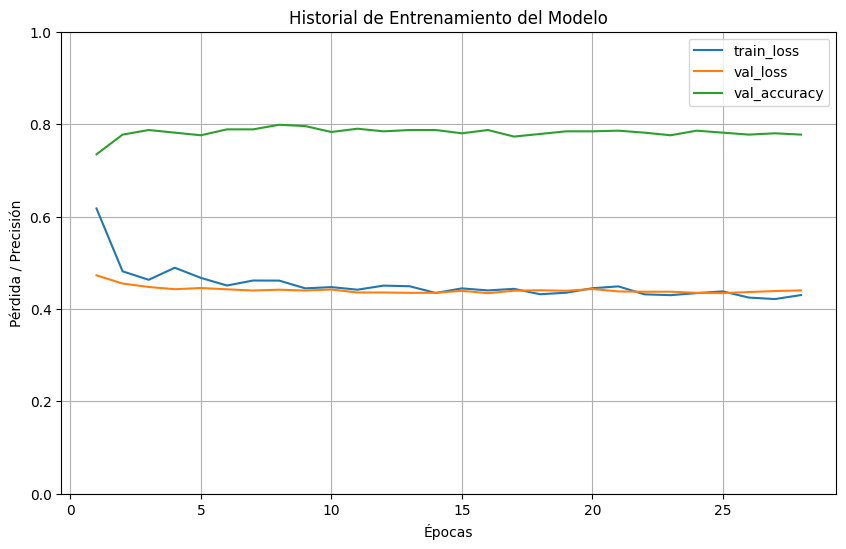

In [ ]:
data = {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies
}
results = pd.DataFrame(data)

results.index = results.index + 1
plt.figure(figsize=(10, 6))
results.plot(ax=plt.gca())
plt.title("Historial de Entrenamiento del Modelo")
plt.xlabel("Épocas")
plt.ylabel("Pérdida / Precisión")
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

## 5. Test final

Una vez que el modelo ha sido entrenado y el mejor conjunto de pesos (basado en la precisión de validación) ha sido guardado, se procede a la evaluación final utilizando el conjunto de prueba (test).

Se carga el "best_model.pth" y se ejecuta la función "get_predictions" para obtener las etiquetas reales y las probabilidades de rotación. Esta fase es crítica porque mide la capacidad de generalización del modelo sobre datos completamente nuevos, proporcionando las métricas definitivas de rendimiento (AUC, Recall, F1-Score) que serán la base para el análisis de negocio y la toma de decisiones.

In [ ]:
model.load_state_dict(torch.load(best_dir))

<All keys matched successfully>

In [ ]:
def get_predictions(model, data_loader, device):
    model.eval()
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            all_targets.extend(targets.cpu().numpy().flatten())
            all_probs.extend(probs.cpu().numpy().flatten())

    return np.array(all_targets), np.array(all_probs)

# Se obtienen los resultados del conjunto de test final
true_labels, churn_probs = get_predictions(model, test_loader, device)

In [ ]:
# Se converte a predicciones binarias (0 o 1)
predicted_labels = (churn_probs >= 0.5).astype(int)

# Clasificación (Precisión, Recall, F1-Score)
print("Métricas de rendimiento (Precisión, Recall, F1-Score):")
print(classification_report(true_labels, predicted_labels, target_names=['No Churn (0)', 'Churn (1)']))

Métricas de rendimiento (Precisión, Recall, F1-Score):
              precision    recall  f1-score   support

No Churn (0)       0.87      0.86      0.87       517
   Churn (1)       0.63      0.63      0.63       187

    accuracy                           0.80       704
   macro avg       0.75      0.75      0.75       704
weighted avg       0.80      0.80      0.80       704



In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

cm_ds = pd.DataFrame(
    cm,
    columns=['Predicted: No Churn (0)', 'Predicted: Churn (1)'],
    index=['True: No Churn (0)', 'True: Churn (1)']
)

cm_ds['Total Real'] = cm_ds.sum(axis=1)
cm_ds.columns.name = 'Predicción'
cm_ds.index.name = 'Realidad'
cm_ds

Predicción,Predicted: No Churn (0),Predicted: Churn (1),Total Real
Realidad,,,
True: No Churn (0),447,70,517
True: Churn (1),69,118,187


In [ ]:
TN, FP, FN, TP = cm.ravel()
print(f"Total Clientes (Churn=1): {TP + FN}")
print(f"Clientes Churn - Correctamente Identificados (Recall): {TP} (Verdaderos Positivos)")
print(f"Clientes Churn - Perdidos (FN): {FN} (Falsos Negativos - El modelo dijo 'No', pero fue 'Sí')")

Total Clientes (Churn=1): 187
Clientes Churn - Correctamente Identificados (Recall): 118 (Verdaderos Positivos)
Clientes Churn - Perdidos (FN): 69 (Falsos Negativos - El modelo dijo 'No', pero fue 'Sí')


Área bajo la Curva ROC:
AUC Score: 0.8443 (Capacidad de discriminación)


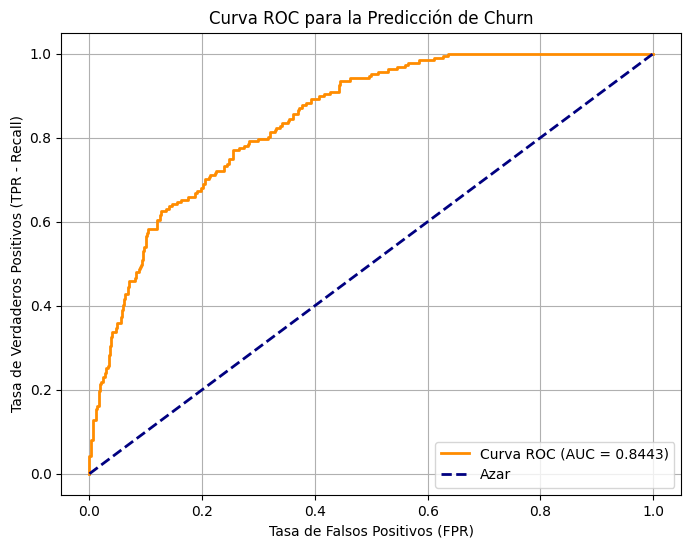

In [ ]:
# Se calcula el AUC
roc_auc = roc_auc_score(true_labels, churn_probs)
print(f"Área bajo la Curva ROC:")
print(f"AUC Score: {roc_auc:.4f} (Capacidad de discriminación)")

fpr, tpr, thresholds = roc_curve(true_labels, churn_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR - Recall)')
plt.title('Curva ROC para la Predicción de Churn')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 6. Cambio del Umbral: Optimización para la retención de clientes

La evaluación inicial reveló que, aunque la precisión general era alta, el modelo estaba perdiendo demasiados clientes en riesgo (falsos negativos). Para priorizar la retención sobre la precisión, se realiza un ajuste estratégico: el umbral de clasificación se reduce de 0.5 a 0.4.

Este cambio desplaza el equilibrio del modelo, haciéndolo más sensible. El objetivo es incrementar la métrica Recall para la clase "Churn (1)", asegurando que se identifique a la mayor cantidad posible de clientes que realmente rotarán, aunque esto implique un ligero aumento de falsos positivos.

In [ ]:
# Se converte a predicciones binarias (0 o 1)
predicted_labels = (churn_probs >= 0.4).astype(int)

# Clasificación (Precisión, Recall, F1-Score)
print("Métricas de rendimiento (Precisión, Recall, F1-Score):")
print(classification_report(true_labels, predicted_labels, target_names=['No Churn (0)', 'Churn (1)']))

Métricas de rendimiento (Precisión, Recall, F1-Score):
              precision    recall  f1-score   support

No Churn (0)       0.89      0.76      0.82       517
   Churn (1)       0.52      0.74      0.61       187

    accuracy                           0.75       704
   macro avg       0.71      0.75      0.71       704
weighted avg       0.79      0.75      0.76       704



In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)

cm_ds = pd.DataFrame(
    cm,
    columns=['Predicted: No Churn (0)', 'Predicted: Churn (1)'],
    index=['True: No Churn (0)', 'True: Churn (1)']
)

cm_ds['Total Real'] = cm_ds.sum(axis=1)
cm_ds.columns.name = 'Predicción'
cm_ds.index.name = 'Realidad'
cm_ds

Predicción,Predicted: No Churn (0),Predicted: Churn (1),Total Real
Realidad,,,
True: No Churn (0),391,126,517
True: Churn (1),49,138,187


In [ ]:
TN, FP, FN, TP = cm.ravel()
print(f"Total Clientes (Churn=1): {TP + FN}")
print(f"Clientes Churn - Correctamente Identificados (Recall): {TP} (Verdaderos Positivos)")
print(f"Clientes Churn - Perdidos (FN): {FN} (Falsos Negativos - El modelo dijo 'No', pero fue 'Sí')")

Total Clientes (Churn=1): 187
Clientes Churn - Correctamente Identificados (Recall): 138 (Verdaderos Positivos)
Clientes Churn - Perdidos (FN): 49 (Falsos Negativos - El modelo dijo 'No', pero fue 'Sí')


Área bajo la Curva ROC:
AUC Score: 0.8443 (Capacidad de discriminación)


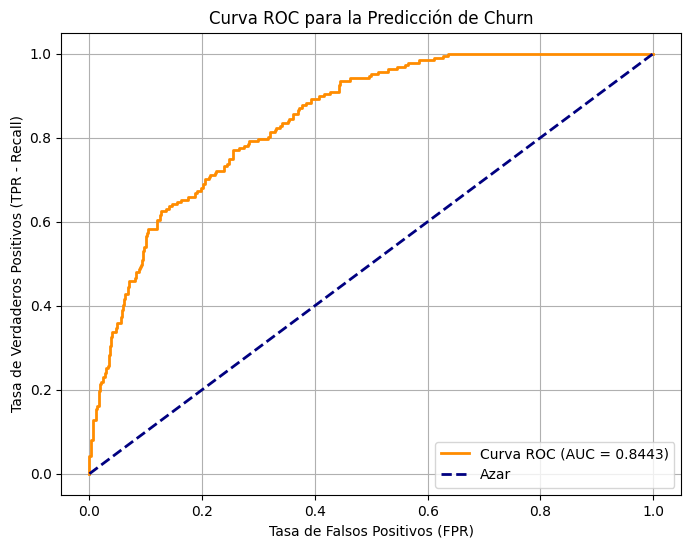

In [ ]:
# Se calcula el AUC
roc_auc = roc_auc_score(true_labels, churn_probs)
print(f"Área bajo la Curva ROC:")
print(f"AUC Score: {roc_auc:.4f} (Capacidad de discriminación)")

fpr, tpr, thresholds = roc_curve(true_labels, churn_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR - Recall)')
plt.title('Curva ROC para la Predicción de Churn')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Ahora se está detectando el 74\% de los clientes que realmente rotarán, en lugar de solo el 63\%, aumentando en un 11\% la precisión de estos y perdiendo solo un 5\% la precisión general. Por lo cual se considera que el umbral de 0.4 es más adecuado para este proyecto de retención de clientes.

El valor de retener a más clientes de alto riesgo supera la ineficiencia de enviar más ofertas de retención a clientes que no las necesitan.

## 7. Exportar datos a Power BI

In [ ]:
test_ds_original = ds_procesado.loc[x_test.index].copy()
test_ds_original = test_ds_original.drop('Churn', axis=1)

ds_resultados = test_ds_original.copy()
ds_resultados['True_Label_Churn'] = true_labels.astype(int)
ds_resultados['Churn_Probability'] = churn_probs
ds_resultados['Predicted_Churn_0_4'] = predicted_labels.astype(int)
ds_resultados['Predicted_Churn_0_5'] = (churn_probs >= 0.5).astype(int)

output_path = '/content/gdrive/MyDrive/Colab Notebooks/churn_para_powerbi.csv'
ds_resultados.to_csv(output_path, index=True)

## 8. Visualización de resultados en Power BI

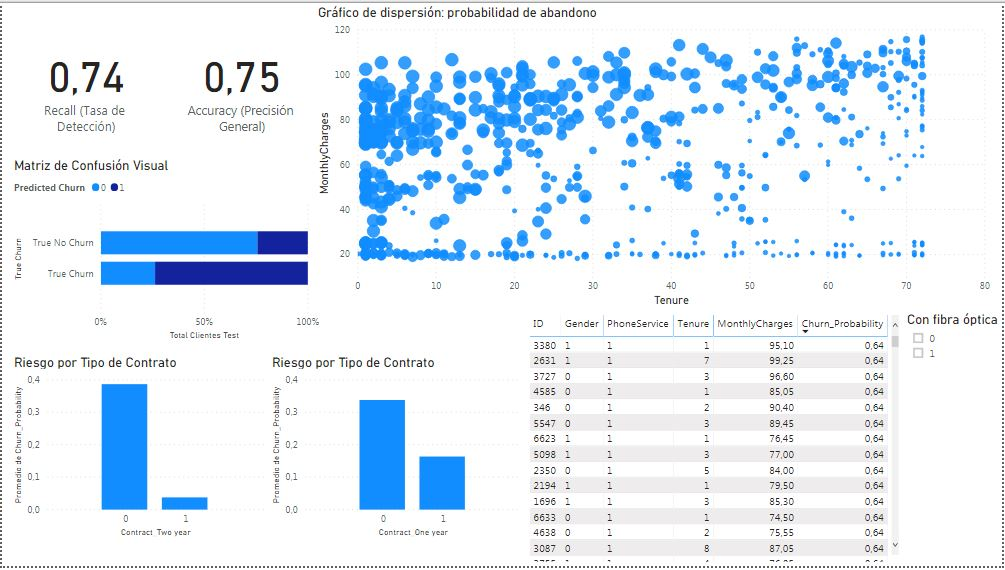

### 1. Rendimiento y Evaluación de Métricas en Power BI

* **Recall (Tasa de Detección): 0.74**
    * **Significado:** De todos los clientes que **realmente rotaron (True Churn)**, el modelo logró identificar correctamente al **74%**.
    * **Resultado:** Este alto valor confirma que el **ajuste del umbral a 0.4** fue efectivo para priorizar la retención de clientes, que era el objetivo de negocio primario.
* **Accuracy (Precisión General): 0.75**
    * **Significado:** La precisión general del modelo tiene un **75%** de acierto.
    * **Resultado:** Se ha logrado un equilibrio exitoso: aumentar la tasa de detección de clientes en riesgo sin sacrificar significativamente la precisión general.
* **Matriz de Confusión Visual:** La visualización confirma que la proporción de clasificaciones correctas es alta. Los segmentos azules representan los errores (Falsos Positivos y Falsos Negativos), los cuales son controlados dada la naturaleza del problema de clasificación de Churn.

---

### 2. Segmentación y Factores de Riesgo

#### A. Riesgo por Tipo de Contrato

* **Contrato de Dos Años:** Muestra una probabilidad de Churn **muy baja** (cercana a cero).
* **Contrato de Un Año:** Muestra una probabilidad **baja/moderada**.
* **Contrato Mes a Mes (Implícito):** Es el tipo de contrato con el **riesgo más alto**.
* **Resultado:** Esto valida la intuición de negocio: la **falta de compromiso a largo plazo** (contrato mes a mes) es el **principal impulsor de la rotación**.

#### B. Gráfico de Dispersión (Antigüedad vs. Cargos Mensuales)

* **Análisis del Eje X (Tenure/Antigüedad) y Eje Y (MonthlyCharges/Cargos Mensuales):** El riesgo de Churn (densidad de puntos) es notablemente alto, especialmente en los clientes con **cargos mensuales altos (en el rango de $80 a $110)**.
* **Resultado:** El riesgo no se limita solo a los clientes nuevos. Los clientes con **mayor antigüedad (Tenure alto)** que tienen **facturas elevadas** también presentan una alta probabilidad de rotación, lo que sugiere una posible **percepción de bajo valor por el precio** o la existencia de mejores ofertas de la competencia.